In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sklearn.datasets
import matplotlib.pyplot as plt

from utils.data.helpers import rotate
from utils.config import config as cfg
from utils.model.train import train_zoo

from utils.model.models import MLP
from utils.visualization.visualize import plot_decision_boundary

import os

In [3]:
# Dataset
X,y = sklearn.datasets.make_moons(n_samples=1000, noise=0.1, random_state=42)

# Normalization
X = (X - X.mean(axis=0)) / X.std(axis=0)

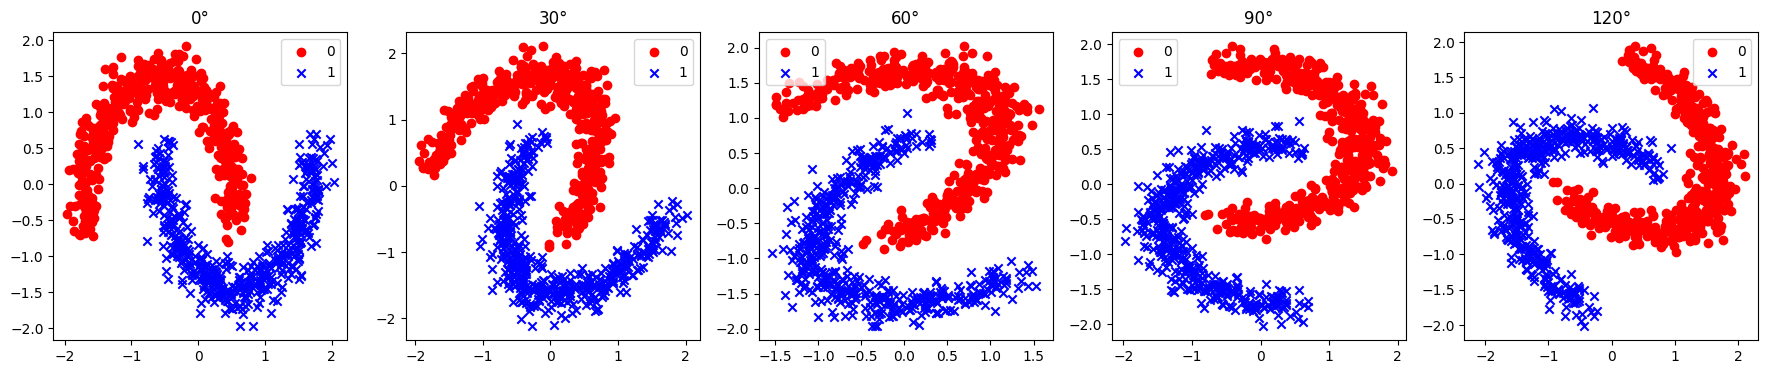

In [4]:
# Vizualization of different rotations
angles = [0, 30, 60, 90, 120]

fig, ax = plt.subplots(1, 5, figsize=(22, 4))

for i, angle in enumerate(angles):
    X_rotated = rotate(X, angle)
    ax[i].scatter(X_rotated[y==0,0], X_rotated[y==0,1], color='red', marker='o')
    ax[i].scatter(X_rotated[y==1,0], X_rotated[y==1,1], color='blue', marker='x')
    ax[i].legend(["0","1"])
    ax[i].set_title(f"{angle}°")

plt.show()

In [6]:
default_dirs = cfg.get_default_dirs()

In [22]:
# Train zoo
config_name = "train_zoo_2_angles.yaml"
config = cfg.load_config(config_name, True)
output_dir = default_dirs["MODELS_DIR"]
train_zoo(config, output_dir)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: idavron (idavron-team). Use `wandb login --relogin` to force relogin


STARTING TRAINING MODEL ZOO
Angles: [0, 90]
Models per angle: 2000


100%|██████████| 2/2 [07:38<00:00, 229.12s/it]


In [7]:
config_name = "train_zoo_4_angles.yaml"
config = cfg.load_config(config_name, True)
output_dir = default_dirs["MODELS_DIR"]
train_zoo(config, output_dir)

STARTING TRAINING MODEL ZOO
Angles: [0, 90, 180, 270]
Models per angle: 2000


100%|██████████| 4/4 [14:34<00:00, 218.67s/it]


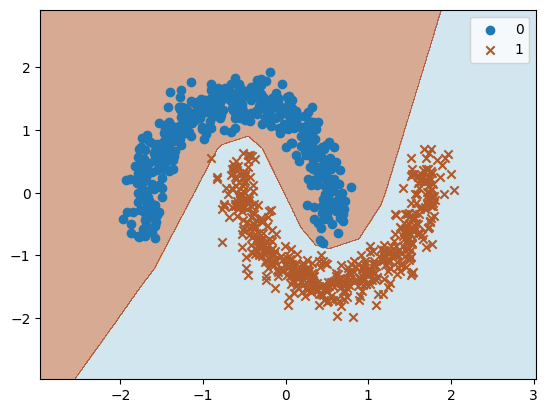

In [9]:
# Plot the decision boundary of the model

default_dirs = cfg.get_default_dirs()
models_dir = default_dirs["MODELS_DIR"]
experiment_name = config["EXPERIMENT_NAME"]


model_config = config["MODEL"]
input_dim = model_config["INPUT_DIM"]
hidden_dims = model_config["HIDDEN_DIMS"]
output_dim = model_config["OUTPUT_DIM"]
model = MLP(input_dim, hidden_dims, output_dim)

experiment_dir = os.path.join(models_dir, experiment_name)
model_path = os.path.join(experiment_dir, "model_180_0.pth")
model.load_state_dict(torch.load(model_path))

plot_decision_boundary(model, X, y)

In [10]:
# Save model parameters into a csv file

from utils.data.make_datasets import models_to_csv

models_dir = default_dirs["MODELS_DIR"]
datasets_dir = default_dirs["DATASETS_DIR"]
experiment_name = config["EXPERIMENT_NAME"]
input_dir = os.path.join(models_dir, experiment_name)
models_to_csv(model_config, input_dir, datasets_dir, f"{experiment_name}.csv")

100%|██████████| 8000/8000 [01:13<00:00, 108.33it/s]


True